# <p style="background-color:skyblue; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;">House Price Prediction 📝</p>

<p style="text-align:center">
    <a href="https://github.com/ITHealer?tab=repositories" target="_blank">
    <img src="avatar_healer.jpg" width="200" alt="Skills Network Logo"  />
    </a>
    <b>Ung Minh Hoài</b> <br>
</p>

# Regression

**Problem Statement**

Một công ty nhà ở có trụ sở tại Hoa Kỳ tên là Surprise Housing đã quyết định thâm nhập thị trường Úc. Công ty sử dụng phân tích dữ liệu để mua nhà ở mức giá thấp hơn giá trị thực của chúng và bán chúng với giá cao hơn. Với mục đích tương tự, công ty đã thu thập một bộ dữ liệu từ việc bán nhà ở Úc. Dữ liệu được cung cấp trong tệp CSV bên dưới.

Công ty đang xem xét các tài sản tiềm năng để mua để tham gia vào thị trường. Bạn được yêu cầu xây dựng mô hình hồi quy bằng cách sử dụng quy tắc hóa để dự đoán giá trị thực của các tài sản tiềm năng và quyết định có nên đầu tư vào chúng hay không.

Công ty muốn biết:

Những biến số nào có ý nghĩa quan trọng trong việc dự đoán giá của một ngôi nhà, và

Những biến đó mô tả giá của một ngôi nhà tốt như thế nào.

#### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor

# hide warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


https://etav.github.io/python/vif_factor_python.html

* Colinearity là trạng thái trong đó hai biến có mối tương quan cao và chứa thông tin giống nhau về phương sai trong một tập dữ liệu nhất định. Để phát hiện sự cộng tuyến giữa các biến, chỉ cần tạo một ma trận tương quan và tìm các biến có giá trị tuyệt đối lớn. (Sử dụng hàm corr trong python)

* Đa cộng tuyến (Multicolinearity) khó phát hiện hơn vì nó xuất hiện khi ba biến trở lên, có mối tương quan cao, được đưa vào trong một mô hình. Để làm cho vấn đề tồi tệ nhất, đa cộng tuyến có thể xuất hiện ngay cả khi các cặp biến bị cô lập không cùng tuyến tính.

CT: $$ VIF = 1 / (1 - R^2). $$

* Hệ số lạm phát phương sai (VIF) là thước đo tính cộng tuyến giữa các biến dự đoán trong một hồi quy bội. Nó được tính bằng cách lấy tỷ lệ phương sai của tất cả các phiên bản beta của một mô hình nhất định chia cho phương sai của một phiên bản beta nếu nó phù hợp với một mình.

Các bước thực hiện VIF
1. Chạy hồi quy bội.
2. Tính toán các yếu tố VIF.
3. Kiểm tra các yếu tố cho từng biến dự đoán, nếu VIF nằm trong khoảng từ 5-10, có khả năng xảy ra hiện tượng đa cộng tuyến và bạn nên cân nhắc bỏ biến đó.

In [3]:
# Function to print null values in all columns (Chức năng in giá trị null trong tất cả các cột)
# variance_inflation_factor : Hệ số lạm phát phương sai (VIF: VIF = 1 / (1 - R^2).)

def nulls(df):
    return (100*round(df.isnull().sum()/len(df),4).sort_values(ascending=False)) # 4: là số chữ số mà số đã cho sẽ được làm tròn đến đó.

def getvif(df):
    if 'const' in list(df.columns):
        df1=df.drop('const', axis=1) 
    else:
        df1 = df.copy()
    vif=pd.DataFrame()
    vif['Features'] = df1.columns
    vif['VIF'] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]
    vif['VIF'] = round(vif.VIF,2)
    vif = vif.sort_values(by = 'VIF', ascending = False)
    return vif

# <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">Table of Content</p>

* [1. Loading Data 💎](#1)
* [2. EDA and Missing Value Treatment 📊](#2)
* [3. Transforming the dependent variable to a normal distribution ⚙️](#3)
* [4. Getting dummy variables for categorical features](#4)
* [5. Test-Train split](#5)
* [6. Scaling of numerical features](#6)
* [7. Building the Model](#7)
    * [7.1. RFE](#8)
    * [7.2. Ridge Regression](#9)
    * [7.3. Lasso Regression](#10)
* [8. Understanding Alpha](#11)
* [9. Re-Run Lasso with Reduced set of input variables](#12)
    

<a id='1'></a>
# 1. Loading Data

In [4]:
#import dataset
df = pd.read_csv('train.csv')

In [5]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<a id='2'></a>
# 2. EDA and Missing Value Treatment

### 2.1. Inspecting df

In [6]:
# inspecting df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 2.2. Checking null values

In [8]:
nulls(df)

PoolQC           99.52
MiscFeature      96.30
Alley            93.77
Fence            80.75
FireplaceQu      47.26
LotFrontage      17.74
GarageYrBlt       5.55
GarageCond        5.55
GarageType        5.55
GarageFinish      5.55
GarageQual        5.55
BsmtFinType2      2.60
BsmtExposure      2.60
BsmtQual          2.53
BsmtCond          2.53
BsmtFinType1      2.53
MasVnrArea        0.55
MasVnrType        0.55
Electrical        0.07
Id                0.00
Functional        0.00
Fireplaces        0.00
KitchenQual       0.00
KitchenAbvGr      0.00
BedroomAbvGr      0.00
HalfBath          0.00
FullBath          0.00
BsmtHalfBath      0.00
TotRmsAbvGrd      0.00
GarageCars        0.00
GrLivArea         0.00
GarageArea        0.00
PavedDrive        0.00
WoodDeckSF        0.00
OpenPorchSF       0.00
EnclosedPorch     0.00
3SsnPorch         0.00
ScreenPorch       0.00
PoolArea          0.00
MiscVal           0.00
MoSold            0.00
YrSold            0.00
SaleType          0.00
SaleConditi

In [9]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [10]:
# Hãy loại bỏ các cột có hơn 90% giá trị null
# Nếu chúng ta gán các giá trị null ở đây, các cột sẽ bị sai lệch (skewed) nhiều và do đó không được sử dụng cho mô hình của chúng ta

nulls_list = nulls(df)
df.drop(list(nulls_list.loc[nulls_list>=90].index),axis=1,inplace=True)
nulls(df)

Fence            80.75
FireplaceQu      47.26
LotFrontage      17.74
GarageYrBlt       5.55
GarageType        5.55
GarageFinish      5.55
GarageQual        5.55
GarageCond        5.55
BsmtExposure      2.60
BsmtFinType2      2.60
BsmtQual          2.53
BsmtCond          2.53
BsmtFinType1      2.53
MasVnrType        0.55
MasVnrArea        0.55
Electrical        0.07
Fireplaces        0.00
KitchenQual       0.00
KitchenAbvGr      0.00
BedroomAbvGr      0.00
HalfBath          0.00
FullBath          0.00
TotRmsAbvGrd      0.00
BsmtHalfBath      0.00
Functional        0.00
BsmtFullBath      0.00
Id                0.00
LowQualFinSF      0.00
GarageCars        0.00
GarageArea        0.00
PavedDrive        0.00
WoodDeckSF        0.00
OpenPorchSF       0.00
EnclosedPorch     0.00
3SsnPorch         0.00
ScreenPorch       0.00
PoolArea          0.00
MiscVal           0.00
MoSold            0.00
YrSold            0.00
SaleType          0.00
SaleCondition     0.00
GrLivArea         0.00
HeatingQC  

In [11]:
# Các giá trị rỗng (Nulls) trong cột Hàng rào (Fence) cho biết không có hàng rào nào trong nhà
df['Fence'].fillna('No Fence',inplace = True)

In [12]:
# Nulls in the FireplaceQu column inidcates no fireplace present in the house
df['FireplaceQu'].fillna('No Fireplace',inplace = True)

In [13]:
# Nulls in the GarageCond, GarageType, GarageYrBlt, GarageFinish, GarageQual column inidcates no Garage present in the house
# Cho biết không có Nhà để xe trong nhà

df['GarageCond'].fillna('No Garage',inplace = True)
df['GarageType'].fillna('No Garage',inplace = True)
df['GarageYrBlt'].fillna('No Garage',inplace = True)
df['GarageQual'].fillna('No Garage',inplace = True)
df['GarageFinish'].fillna('No Garage',inplace = True)

In [14]:
# Nulls in the BsmtExposure, BsmtFinType2, BsmtFinType1, BsmtCond, BsmtQual column inidcates no basement present in the house
# Không có tầng hầm trong nhà

df['BsmtExposure'].fillna('No Basement',inplace = True)
df['BsmtFinType2'].fillna('No Basement',inplace = True)
df['BsmtFinType1'].fillna('No Basement',inplace = True)
df['BsmtCond'].fillna('No Basement',inplace = True)
df['BsmtQual'].fillna('No Basement',inplace = True)

In [15]:
# Nulls in the MasVnrArea, MasVnrType column inidcates no Masonry Veneer present in the house

df['MasVnrArea'].fillna(0,inplace = True)
df['MasVnrType'].fillna('None',inplace = True)

In [16]:
# Replacing nulls in LotFrontage with 0 (no frontage) thay thế null trong LotFrontage bằng 0 (không có mặt tiền)

df['LotFrontage'].fillna(0,inplace = True)

In [17]:
# Checking Electrical

df.Electrical.value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [18]:
# Replacing nulls in Electrical with mode

df['Electrical'].fillna('SBrkr',inplace = True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

### 2.3. Loại bỏ các trường không cần thiết

In [20]:
# Checking YearBuilt to Age

df['Age'] = 2022 - df['YearBuilt']

In [21]:
# Dropping the YearBuilt variables since we won't need to use these, age will suffice for our goal
# Bỏ các biến YearBuilt vì chúng ta sẽ không cần sử dụng các biến này, tuổi (Age) sẽ đủ cho mục tiêu.

df.drop(['YearBuilt','YrSold','YearRemodAdd','GarageYrBlt','MoSold'],axis=1,inplace=True)

In [22]:
# 'SaleType' would not be available to us while making predicitons (it is part of target variable), hence we will drop it. 
# 'SaleType' sẽ không có sẵn cho chúng tôi khi đưa ra dự đoán (nó là một phần của biến mục tiêu), do đó chúng ta sẽ loại bỏ nó.

df.drop(['SaleType'],axis=1,inplace=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  RoofStyl

### 2.4. Biến phân loại

In [24]:
# df_category = df.select_dtypes(include=['object'])
# df_category

In [25]:
# We can perform label encoding for some cardinal categorical variables, which have an order to them
# Chúng ta có thể thực hiện mã hóa nhãn cho một số biến phân loại cơ bản, có thứ tự đối với chúng

df['LandSlope'] = df['LandSlope'].map({'Gtl':3, 'Mod':2,'Sev':1})
df['LotShape'] = df['LotShape'].map({'Reg':4, 'IR1':3,'IR2':2,'IR3':1})
df['Utilities'] = df['Utilities'].map({'AllPub':4, 'NoSewr':3,'NoSeWa':2,'ELO':1})
df['ExterQual'] = df['ExterQual'].map({'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1})
df['ExterCond'] = df['ExterCond'].map({'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1})
df['BsmtQual'] = df['BsmtQual'].map({'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1,'No Basement':0})
df['BsmtCond'] = df['BsmtCond'].map({'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1,'No Basement':0})
df['BsmtExposure'] = df['BsmtExposure'].map({'Gd':4,'Av':3,'Mn':2,'No':1,'No Basement':0})
df['BsmtFinType1'] = df['BsmtFinType1'].map({'GLQ':6,'ALQ':5, 'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'No Basement':0})
df['BsmtFinType2'] = df['BsmtFinType2'].map({'GLQ':6,'ALQ':5, 'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'No Basement':0})
df['HeatingQC'] = df['HeatingQC'].map({'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1})
df['Electrical'] = df['Electrical'].map({'SBrkr':5, 'FuseA':4,'FuseF':3,'FuseP':2,'Mix':1})
df['KitchenQual'] = df['KitchenQual'].map({'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1})
df['Functional'] = df['Functional'].map({'Typ':8,'Min1':7,'Min2':6,'Mod':5, 'Maj1':4,'Maj2':3,'Sev':2,'Sal':1})
df['FireplaceQu'] = df['FireplaceQu'].map({'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1,'No Fireplace':0})
df['GarageFinish'] = df['GarageFinish'].map({'Fin':4,'RFn':3,'Unf':2,'No Garage':1})
df['GarageQual'] = df['GarageQual'].map({'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1,'No Garage':0})
df['GarageCond'] = df['GarageCond'].map({'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1,'No Garage':0})
df['PavedDrive'] = df['PavedDrive'].map({'Y':3, 'P':2,'N':1})
df['Fence'] = df['Fence'].map({'GdPrv':4,'MnPrv':3,'GdWo':2,'MnWw':1,'No Fence':0})

In [26]:
# We have dealt with all the null values in the dataset (Chúng tôi đã xử lý tất cả các giá trị null trong tập dữ liệu)
nulls(df)

Id               0.0
HeatingQC        0.0
Fireplaces       0.0
Functional       0.0
TotRmsAbvGrd     0.0
KitchenQual      0.0
KitchenAbvGr     0.0
BedroomAbvGr     0.0
HalfBath         0.0
FullBath         0.0
BsmtHalfBath     0.0
BsmtFullBath     0.0
GrLivArea        0.0
LowQualFinSF     0.0
2ndFlrSF         0.0
1stFlrSF         0.0
Electrical       0.0
FireplaceQu      0.0
GarageType       0.0
GarageFinish     0.0
3SsnPorch        0.0
SalePrice        0.0
SaleCondition    0.0
MiscVal          0.0
Fence            0.0
PoolArea         0.0
ScreenPorch      0.0
EnclosedPorch    0.0
GarageCars       0.0
OpenPorchSF      0.0
WoodDeckSF       0.0
PavedDrive       0.0
GarageCond       0.0
GarageQual       0.0
GarageArea       0.0
CentralAir       0.0
Heating          0.0
MSSubClass       0.0
TotalBsmtSF      0.0
OverallQual      0.0
HouseStyle       0.0
BldgType         0.0
Condition2       0.0
Condition1       0.0
Neighborhood     0.0
LandSlope        0.0
LotConfig        0.0
Utilities    

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   int64  
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   int64  
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   int64  
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  RoofStyl

In [28]:
df['MSSubClass'].head()

0    60
1    20
2    60
3    70
4    60
Name: MSSubClass, dtype: int64

In [29]:
# Changing class to categorical

df['MSSubClass'] = df['MSSubClass'].astype('object')

In [30]:
# We have these categorical variables now (Bây giờ chúng ta có các biến phân loại này)

cat_vars = list(set(df.drop('Id',axis=1).columns) - set(df._get_numeric_data().columns))
cat_vars

['SaleCondition',
 'LandContour',
 'Street',
 'HouseStyle',
 'LotConfig',
 'Foundation',
 'RoofMatl',
 'Condition2',
 'Neighborhood',
 'Condition1',
 'MSSubClass',
 'RoofStyle',
 'Exterior1st',
 'MSZoning',
 'CentralAir',
 'Exterior2nd',
 'Heating',
 'BldgType',
 'MasVnrType',
 'GarageType']

In [31]:
# Adding convereted cateogrical variables too (Thêm các biến phân loại đã chuyển đổi ở trên)

for each in ['LandSlope','LotShape','Utilities','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtQual','BsmtFinType1','BsmtFinType2','HeatingQC','Electrical','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','Fence']:
    cat_vars.append(each)

In [32]:
len(cat_vars)

41

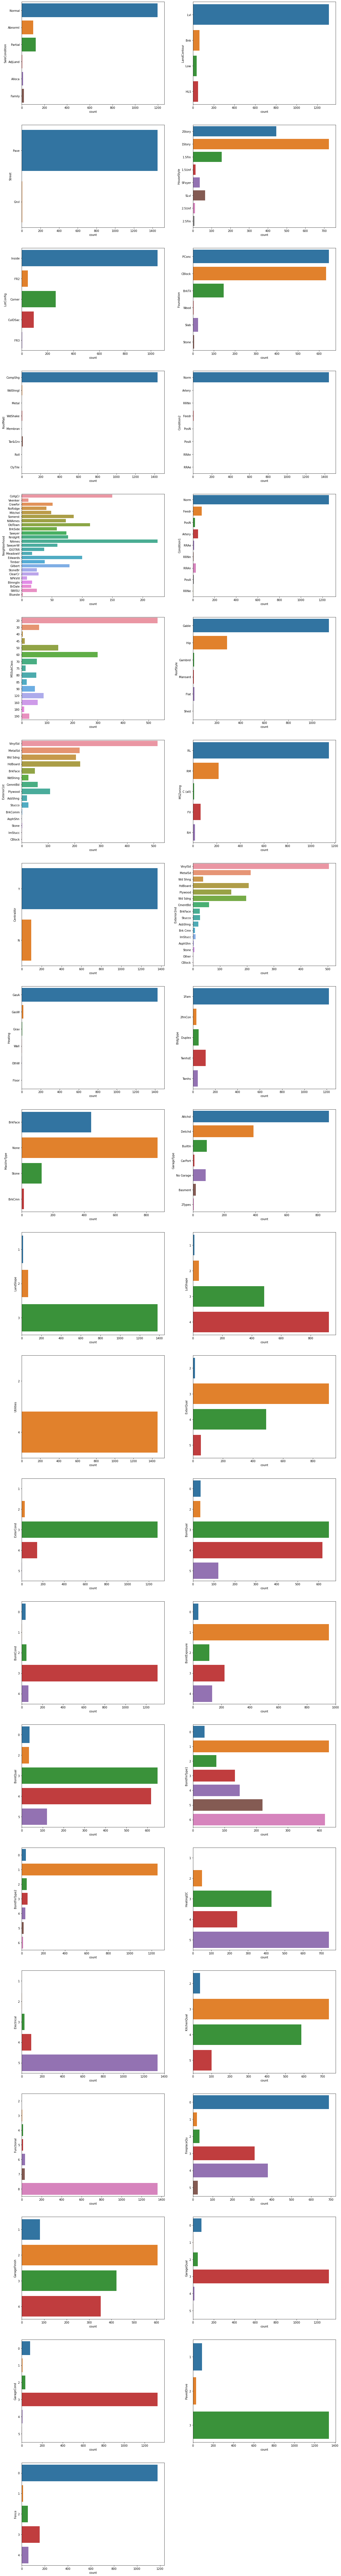

In [33]:
#We will be inspecting all the cateogrical columns now (Bây giờ chúng tôi sẽ kiểm tra tất cả các cột phân loại)

plt.figure(figsize=(20,8*26))
for i, each in enumerate(cat_vars):
    plt.subplot(26,2,i+1)
    sns.countplot(y=df[each])

In [34]:
#from the above plots, we can spot some features with a consider amount of skewing in the data.
#We will analyze how much skewed the data exactly is, and then take action based on that.
#As a benchmark, features with more than 90% of data belonging to one category can be set as skewed
#We will find which of our categorical columns can be cateogirzed as skewed

# Từ các biểu đồ trên, chúng ta có thể phát hiện ra một số tính năng có mức độ sai lệch đáng kể trong dữ liệu.
# Chúng tôi sẽ phân tích chính xác mức độ sai lệch của dữ liệu và sau đó thực hiện hành động dựa trên đó.
# Là điểm chuẩn, các tính năng có hơn 90% dữ liệu thuộc về một danh mục có thể được đặt thành sai lệch
# Chúng tôi sẽ tìm cột phân loại nào của chúng tôi có thể được phân loại là sai lệch

skewed_cols = []
for each in cat_vars:
    if max(df[each].value_counts(normalize=True)*100) > 90:
        print(df[each].value_counts(normalize=True)*100)
        print('\n')
        skewed_cols.append(each)

Pave    99.589041
Grvl     0.410959
Name: Street, dtype: float64


CompShg    98.219178
Tar&Grv     0.753425
WdShngl     0.410959
WdShake     0.342466
Metal       0.068493
Membran     0.068493
Roll        0.068493
ClyTile     0.068493
Name: RoofMatl, dtype: float64


Norm      98.972603
Feedr      0.410959
Artery     0.136986
RRNn       0.136986
PosN       0.136986
PosA       0.068493
RRAn       0.068493
RRAe       0.068493
Name: Condition2, dtype: float64


Y    93.493151
N     6.506849
Name: CentralAir, dtype: float64


GasA     97.808219
GasW      1.232877
Grav      0.479452
Wall      0.273973
OthW      0.136986
Floor     0.068493
Name: Heating, dtype: float64


3    94.657534
2     4.452055
1     0.890411
Name: LandSlope, dtype: float64


4    99.931507
2     0.068493
Name: Utilities, dtype: float64


5    91.438356
4     6.438356
3     1.849315
2     0.205479
1     0.068493
Name: Electrical, dtype: float64


8    93.150685
6     2.328767
7     2.123288
5     1.027397
4     0.95890

In [35]:
# We now have the following heavily skewed columns where more than 90% of values belong to a single category only
# Hiện tại, chúng tôi có các cột bị lệch nặng sau đây, trong đó hơn 90% giá trị chỉ thuộc về một danh mục duy nhất

skewed_cols

['Street',
 'RoofMatl',
 'Condition2',
 'CentralAir',
 'Heating',
 'LandSlope',
 'Utilities',
 'Electrical',
 'Functional',
 'GarageCond',
 'PavedDrive']

In [36]:
# Dropping heavily skewed columns for a cleaner dataset
# Loại bỏ các cột bị lệch nhiều để có tập dữ liệu sạch hơn

df.drop(skewed_cols, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 62 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   object 
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   LotShape       1460 non-null   int64  
 6   LandContour    1460 non-null   object 
 7   LotConfig      1460 non-null   object 
 8   Neighborhood   1460 non-null   object 
 9   Condition1     1460 non-null   object 
 10  BldgType       1460 non-null   object 
 11  HouseStyle     1460 non-null   object 
 12  OverallQual    1460 non-null   int64  
 13  OverallCond    1460 non-null   int64  
 14  RoofStyle      1460 non-null   object 
 15  Exterior1st    1460 non-null   object 
 16  Exterior2nd    1460 non-null   object 
 17  MasVnrType     1460 non-null   object 
 18  MasVnrAr

### 2.5. Biến số 

In [37]:
# We now look at how the numerical variables are spread
# Bây giờ chúng ta xem xét các biến số được trải rộng như thế nào

num_vars = list(df.drop('Id',axis=1)._get_numeric_data().columns)
num_vars

['LotFrontage',
 'LotArea',
 'LotShape',
 'OverallQual',
 'OverallCond',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'HeatingQC',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Fireplaces',
 'FireplaceQu',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'Fence',
 'MiscVal',
 'SalePrice',
 'Age']

In [38]:
len(num_vars)

46

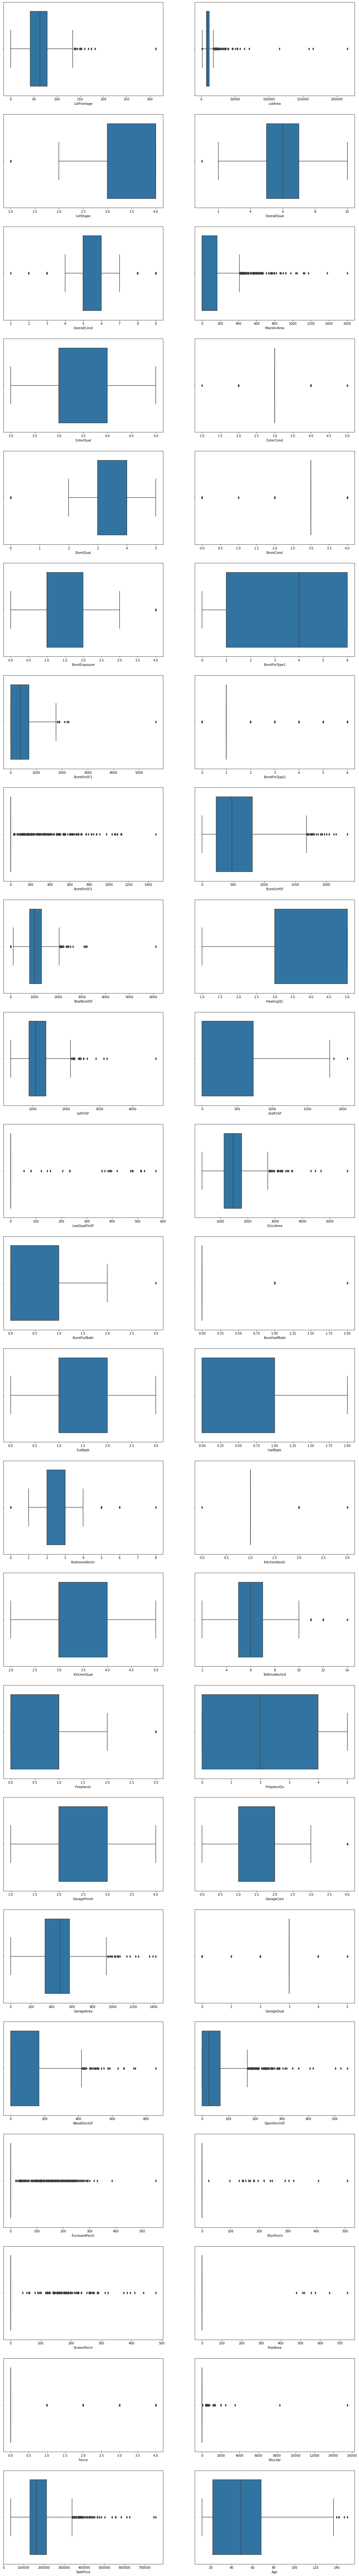

In [39]:
#We will be inspecting all the numerical columns now

plt.figure(figsize=(20,8*22))
for i,each in enumerate(num_vars):
    plt.subplot(27,2,i+1)
    sns.boxplot(x=df[each])

**Giải thích thêm**

* Boxplot thể hiện các phân phối dữ liệu, nghĩa là giúp chúng ta biết được độ dàn trải của các điểm dữ liệu như thế nào, dữ liệu có đối xứng không, phân bố rộng hay hẹp, giá trị nhỏ nhất, lớn nhất và các điểm ngoại lệ.

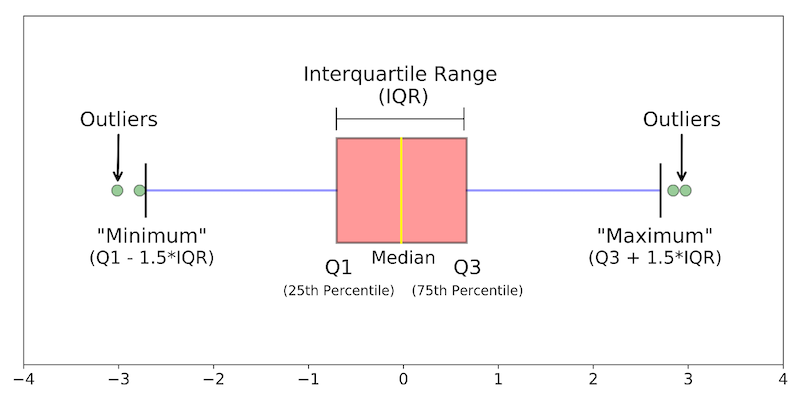

* Nếu xu hướng tập trung của dữ liệu (trung vị) ở mức cao, độ dao động lớn -> không tốt (bị lệch)

* Nếu dữ liệu về tỉ lệ tập trung ở mức thấp, dao động ở phạm vi hẹp. -> thì tốt hơn trường hợp trên(chấp nhận được).

* Nếu cân bằng là tốt nhất

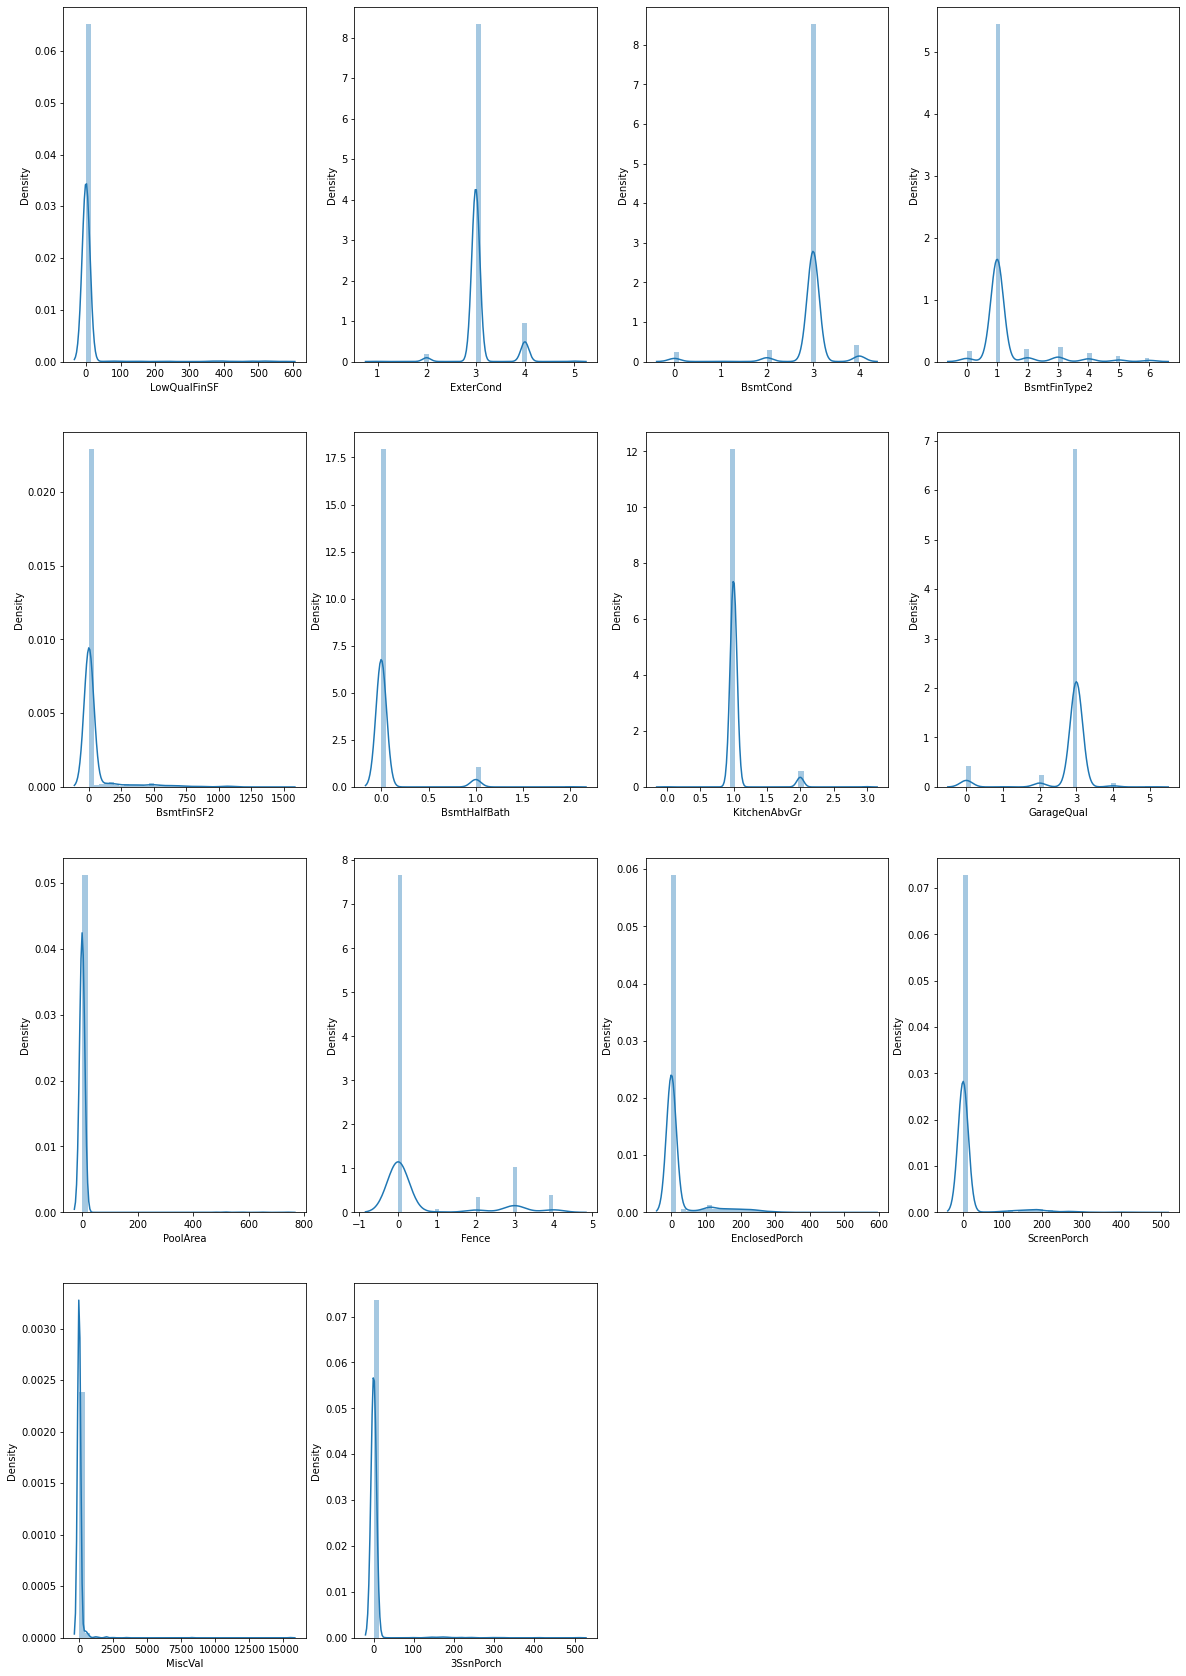

In [40]:
# Certain features are highly skewed here. We can drop them to simplify our model
# before dropping, we look at their actual spread
# Một số tính năng rất sai lệch ở đây. Chúng ta có thể bỏ chúng để đơn giản hóa mô hình của chúng ta
# trước khi giảm, chúng tôi xem xét mức chênh lệch thực tế của chúng

i=1
plt.figure(figsize=(20,30))
for each in ['LowQualFinSF','ExterCond','BsmtCond','BsmtFinType2','BsmtFinSF2','BsmtHalfBath','KitchenAbvGr','GarageQual','PoolArea','Fence','EnclosedPorch','ScreenPorch','MiscVal','3SsnPorch']:
    plt.subplot(4,4,i)
    sns.distplot(df[each])
    i+=1

In [41]:
# Dropping more skewed features

df.drop(['LowQualFinSF','ExterCond','BsmtCond','BsmtFinType2','BsmtFinSF2','BsmtHalfBath','KitchenAbvGr','GarageQual','PoolArea','Fence','EnclosedPorch','ScreenPorch','MiscVal','3SsnPorch'],axis=1,inplace=True)

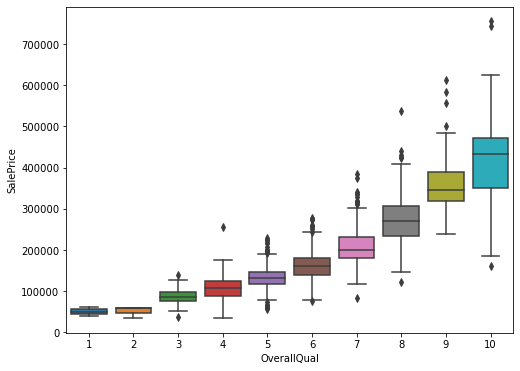

In [42]:
# let's see how sale price is varying across overall quality rating of the house
# Hãy xem giá bán thay đổi như thế nào theo xếp hạng chất lượng tổng thể của ngôi nhà

data = pd.concat([df['SalePrice'], df['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='OverallQual', y="SalePrice", data=data)

# fig.axis(ymin=0, ymax=800000);

* Gía tiền tăng khi chất lượng tổng thể ngôi nhà tăng -> hợp lý

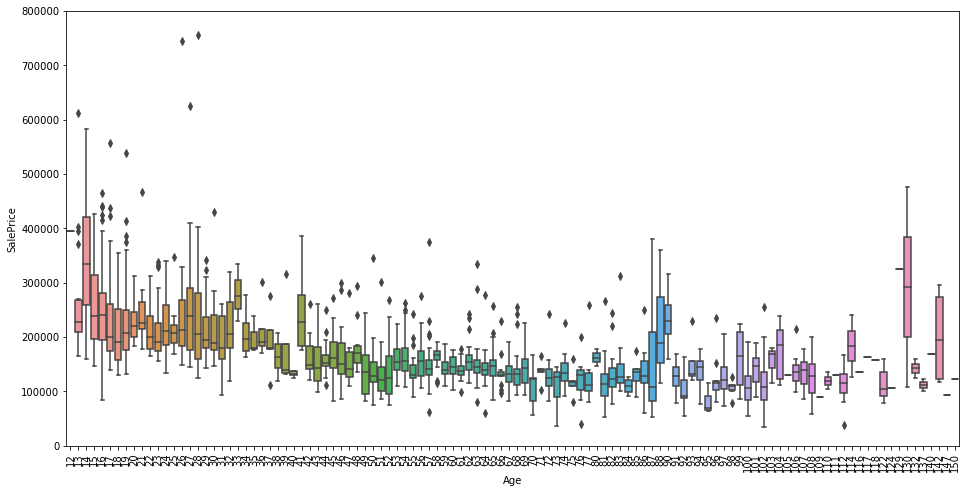

In [43]:
# Giá_bán (Sale price) còn liên quan đến tuổi của ngôi nhà tuổi cao không nhất thiết có nghĩa là giá sẽ thấp,
# nhưng xu hướng chung là giảm nhẹ

data = pd.concat([df['SalePrice'], df['Age']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x='Age', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

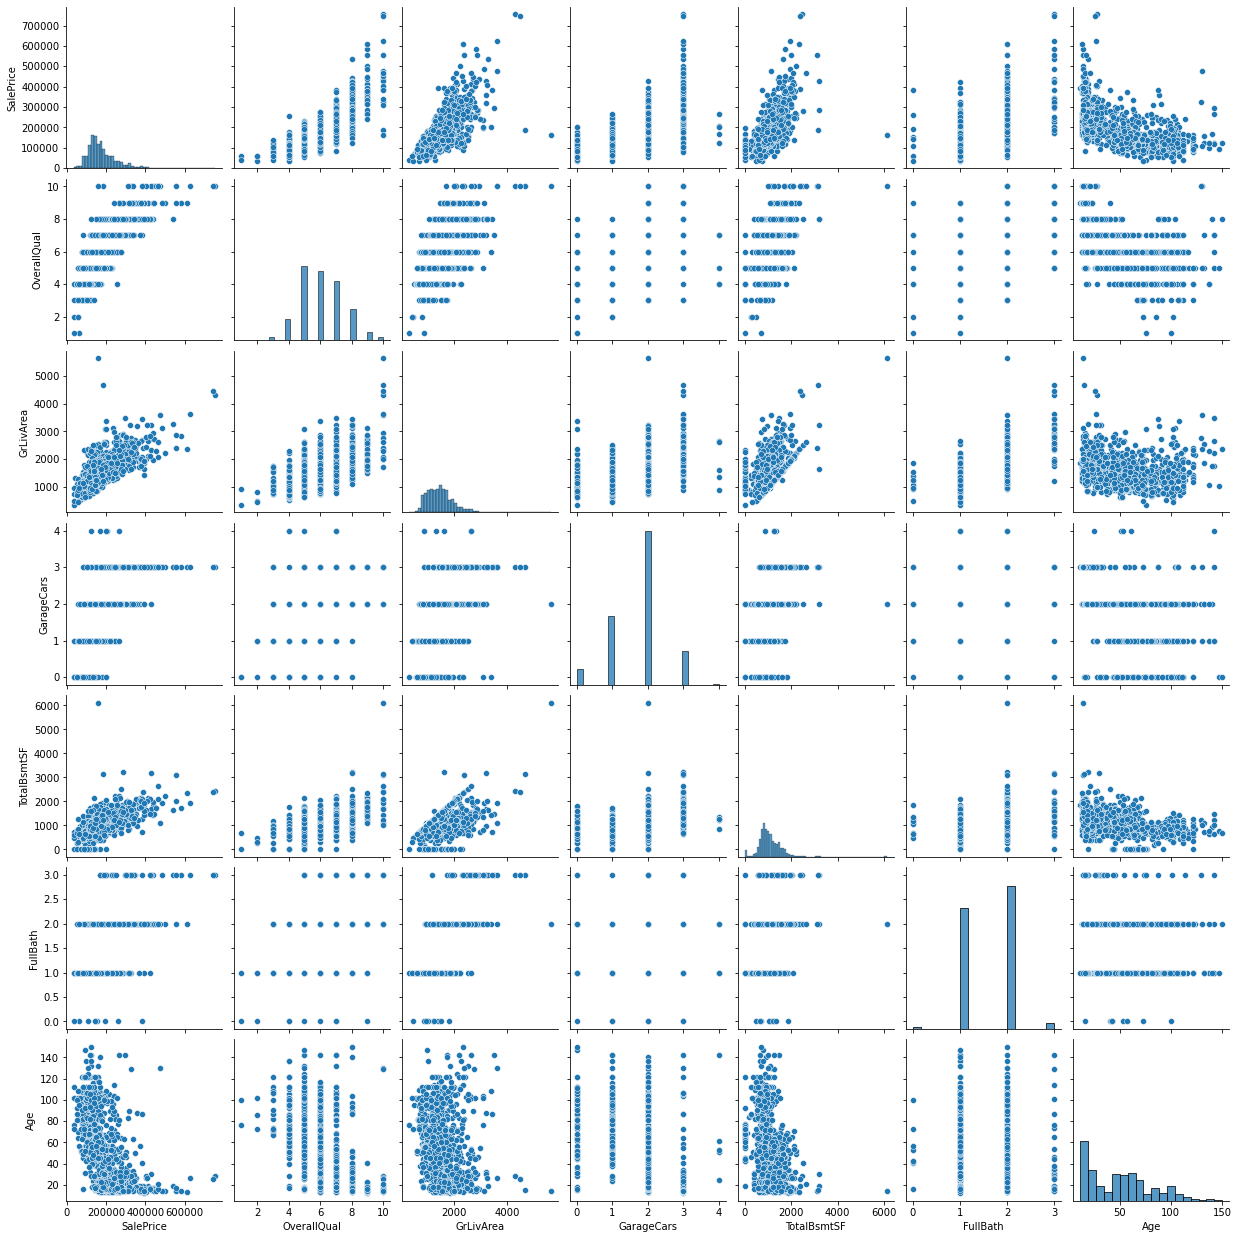

In [44]:
# Chúng ta có thể thấy một số tính năng quan trọng có tác động lẫn nhau như thế nào.

sns.pairplot(df[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'Age']], size = 2.5)
plt.show()

* We find there is a considerable amount of variance in the data
* We choose not to perform outlier value treatment, since these features are what might be impacting prices of the house

* Chúng tôi thấy có một số lượng đáng kể phương sai trong dữ liệu

* Chúng tôi chọn không thực hiện xử lý giá trị ngoại lai, vì những tính năng này có thể ảnh hưởng đến giá của ngôi nhà

<a id='3'></a>
# 3. Transforming the dependent variable to a normal distribution

Để thỏa mãn các giả định của hồi quy tuyến tính, biến mục tiêu (biến phụ thuộc) phải có phân phối chuẩn. Chúng ta có thể thấy trong distplot bên dưới rằng của chúng ta rất lệch về bên phải. Bây giờ chúng tôi sẽ giải quyết vấn đề này để có được hiệu suất tốt hơn

<h2>Skewness</h2>

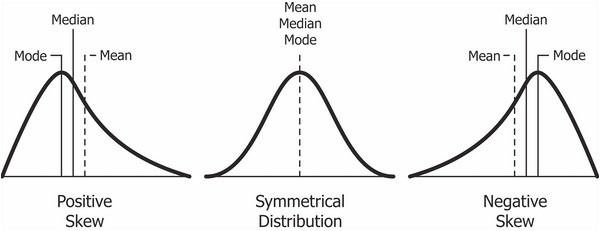

Mean > Median > Mode (+vely skewed)

Mode > Median > Mean (-vely skewed)

<h2>Kurtoris</h2>

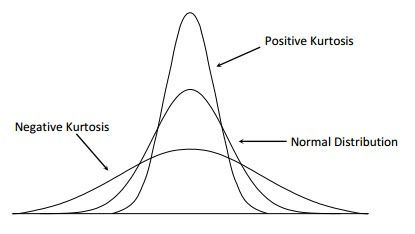

https://www.turing.com/kb/calculating-skewness-and-kurtosis-in-python

Skewness là một thước đo thống kê về phân phối không đối xứng của dữ liệu.

Kurtosis giúp xác định xem phân phối có nhiều đuôi so với phân phối chuẩn hay không.

<b>Skewness:</b>

Một xiên dương sẽ chỉ ra rằng đuôi nằm ở phía bên phải. Nó sẽ mở rộng về phía các giá trị tích cực nhất.

Mặt khác, một xiên âm sẽ chỉ ra một cái đuôi ở phía bên trái và sẽ kéo dài sang phía tiêu cực hơn.

Giá trị 0 sẽ chỉ ra rằng không có độ lệch trong phân phối, có nghĩa là phân phối hoàn toàn đối xứng.

Sự phân bố của các giá trị độ lệch như sau:

● Độ xiên = 0 khi phân phối chuẩn.

● Độ xiên> 0 hoặc dương khi có nhiều trọng số hơn ở bên trái của phân phối.

● Độ xiên <0 hoặc âm khi có nhiều trọng số hơn ở phía bên phải của phân phối.

<b>Kurtosis:</b>

Kurtosis là một thuật ngữ thống kê đặc trưng cho sự phân bố tần số. Ngoài việc xác định xem phân phối có nhiều đuôi hay không, nó cũng cung cấp thông tin chi tiết về hình dạng của phân bố tần số.

● Kurtosis có phân phối chuẩn bằng 3.

● Khi kurtosis nhỏ hơn 3, nó được gọi là Platykurtic

● Khi lớn hơn 3, nó là leptokurtic

Nếu nó là leptokurtic, nó sẽ biểu thị rằng nó tạo ra các giá trị ngoại lai chứ không phải là một phân phối chuẩn.

Phân phối chuẩn khi biểu đồ xác suất này có quan hệ tuyến tính (đường thẳng)

Nếu nó vi phạm các độ lệch trên có nghĩa là nó có xu hướng tạo ra nhiều giá trị ngoại lai hơn so với phân phối chuẩn.

https://www.statology.org/skewness-kurtosispython/#:~:text=To%20calculate%20the%20sample%20skewness,of%20values%2C%20bias%3DFalse

https://www.geeksforgeeks.org/how-to-calculate-skewness-and-kurtosis-in-python/

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

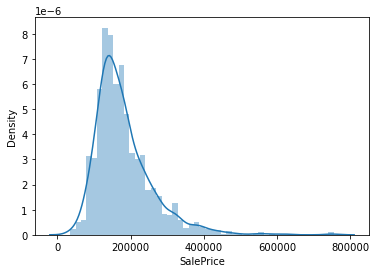

In [45]:
#target variable
sns.distplot(df['SalePrice'])

In [46]:
# Chúng tôi lưu ý rằng biến mục tiêu - target (phụ thuộc - dependent) 
# không có phân phối hoàn toàn bình thường (normal distribution) và có một số sai lệch (skewness).

In [47]:
# The variable is quite skewed, and all the values are positive (boxcox can be used here)
# Biến bị lệch khá nhiều và tất cả các giá trị đều dương (có thể sử dụng boxcox tại đây)
df.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [48]:
# There is a high degree of skew in this column (Có độ lệch cao trong cột này)
df.SalePrice.skew()

1.8828757597682129

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

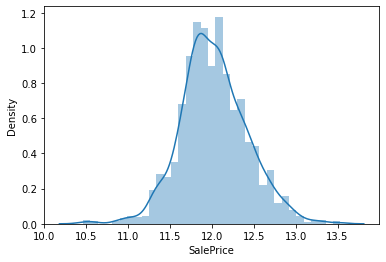

In [49]:
# We try log transformation

from math import log
sns.distplot(df.SalePrice.apply(lambda x: log(x)))

In [50]:
# We are able to get the skew down to a great extent by using log transform
# Chúng ta có thể giảm độ lệch xuống ở mức độ lớn bằng cách sử dụng log

df.SalePrice.apply(lambda x: log(x)).skew()

0.12133506220520406

In [51]:
# We can use Box-Cox Transform to reduce the skew further and make the data resemble a normal distribution
# Chúng ta có thể sử dụng Box-Cox Transform để giảm độ lệch hơn nữa và làm cho dữ liệu giống với phân phối bình thường

from scipy import stats as ss
df['SalePrice'] = pd.Series(ss.boxcox(df.SalePrice)[0])
df.SalePrice.skew()

-0.008652893640830005

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

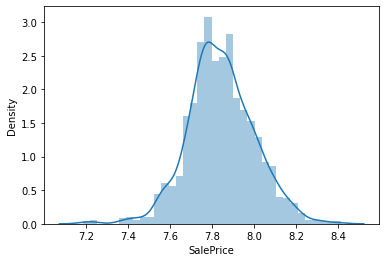

In [52]:
#We can see that the distribution is much closer to normal now, hence we can fit a linear regression model effectively
sns.distplot(df.SalePrice)

<a id='4'></a>
# 4. Getting dummy variables for categorical features

In [53]:
# Updating list of categorical variables
cat_vars = list(set(df.drop('Id',axis=1).columns) - set(df._get_numeric_data().columns))
cat_vars

['RoofStyle',
 'SaleCondition',
 'LandContour',
 'Exterior1st',
 'MSZoning',
 'BldgType',
 'MasVnrType',
 'HouseStyle',
 'Foundation',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'MSSubClass',
 'Exterior2nd',
 'GarageType']

In [54]:
# creating dataframe with dummy variables
dummy = pd.get_dummies(df[cat_vars], drop_first = True)
dummy.head()

,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,LandContour_HLS,LandContour_Low,LandContour_Lvl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No Garage
0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0


In [55]:
# merging dummy variables into original dataframe
df = pd.concat([df,dummy],axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 169 entries, Id to GarageType_No Garage
dtypes: float64(3), int64(30), object(15), uint8(121)
memory usage: 720.1+ KB


In [56]:
# dropping original categorical variables that have been dummified (loại bỏ các biến phân loại ban đầu đã bị làm giả)
df.drop(cat_vars,axis=1,inplace=True)
df.shape

(1460, 154)

<a id='5'></a>
# 5. Test-Train split

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
x = df.drop(['SalePrice','Id'], axis = 1)
y = df[['SalePrice']]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.75, random_state = 44)

In [59]:
x_train.shape

(1095, 152)

In [60]:
x_test.shape

(365, 152)

In [61]:
y_train.shape

(1095, 1)

In [62]:
y_test.shape

(365, 1)

<a id='6'></a>
# 6. Scaling of numerical features

In [63]:
# Để có thể diễn giải mô hình cuối cùng và để hội tụ nhanh hơn, chúng tôi sẽ mở rộng các tính năng của mình
# Chúng tôi đã chọn MinMax Scaler cho quy trình

In [64]:
from sklearn.preprocessing import MinMaxScaler

In [65]:
scaler = MinMaxScaler() #initializing minmaxscaler
num_vars = list(set(num_vars) - set(['KitchenAbvGr', 'ScreenPorch', 'Fence', 'BsmtHalfBath', '3SsnPorch', 'PoolArea', 'BsmtCond', 'EnclosedPorch', 'LowQualFinSF', 'MiscVal', 'GarageQual', 'BsmtFinSF2', 'BsmtFinType2', 'ExterCond','SalePrice'])) #removing saleprice since it is not in x_train now

In [66]:
# We will be scaling only the orignal continous variables. Dummy variables can be used as-is.
x_train[list(num_vars)].describe()

,GarageCars,Age,LotArea,LotShape,HeatingQC,GarageFinish,WoodDeckSF,MasVnrArea,2ndFlrSF,TotRmsAbvGrd,BsmtFullBath,ExterQual,LotFrontage,HalfBath,BedroomAbvGr,FireplaceQu,Fireplaces,BsmtQual,KitchenQual,BsmtFinType1,OpenPorchSF,OverallQual,OverallCond,BsmtFinSF1,BsmtUnfSF,GrLivArea,1stFlrSF,FullBath,GarageArea,TotalBsmtSF,BsmtExposure
count,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,1.788128,50.322374,10585.533333,3.576256,4.125114,2.719635,93.802740,106.187215,348.622831,6.564384,0.420091,3.392694,57.211872,0.389041,2.882192,1.825571,0.613699,3.493151,3.511416,3.559817,46.794521,6.122374,5.562557,453.461187,570.246575,1528.781735,1174.587215,1.562557,477.978082,1069.564384,1.601826
std,0.741093,29.859715,9165.568230,0.585772,0.968356,0.889163,127.759055,185.011390,438.990563,1.629036,0.513758,0.577726,36.026179,0.506149,0.832280,1.808896,0.643910,0.880262,0.664872,2.094616,66.321283,1.388646,1.113103,465.639938,444.754799,534.224087,394.371040,0.543757,213.122278,447.521273,1.044878
min,0.000000,12.000000,1300.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,334.000000,334.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,22.000000,7667.500000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000,6.000000,0.000000,3.000000,40.000000,0.000000,2.000000,0.000000,0.000000,3.000000,3.000000,1.000000,0.000000,5.000000,5.000000,0.000000,224.000000,1140.000000,888.500000,1.000000,337.000000,804.000000,1.000000
50%,2.000000,48.000000,9572.000000,4.000000,4.000000,3.000000,0.000000,0.000000,0.000000,6.000000,0.000000,3.000000,63.000000,0.000000,3.000000,2.000000,1.000000,4.000000,3.000000,4.000000,24.000000,6.000000,5.000000,387.000000,476.000000,1472.000000,1098.000000,2.000000,480.000000,1004.000000,1.000000
75%,2.000000,68.000000,11740.500000,4.000000,5.000000,3.000000,168.000000,168.000000,729.500000,7.000000,1.000000,4.000000,79.000000,1.000000,3.000000,4.000000,1.000000,4.000000,4.000000,6.000000,69.000000,7.000000,6.000000,719.500000,812.500000,1795.500000,1418.000000,2.000000,576.000000,1303.000000,2.000000
max,4.000000,142.000000,164660.000000,4.000000,5.000000,4.000000,857.000000,1600.000000,2065.000000,14.000000,2.000000,5.000000,313.000000,2.000000,8.000000,5.000000,3.000000,5.000000,5.000000,6.000000,547.000000,10.000000,9.000000,5644.000000,2336.000000,5642.000000,4692.000000,3.000000,1418.000000,6110.000000,4.000000


In [67]:
# fitting the scaler on train set and transforming variables
x_train[num_vars] = scaler.fit_transform(x_train[num_vars])
x_train[num_vars].describe()

,GarageCars,Age,LotArea,LotShape,HeatingQC,GarageFinish,WoodDeckSF,MasVnrArea,2ndFlrSF,TotRmsAbvGrd,BsmtFullBath,ExterQual,LotFrontage,HalfBath,BedroomAbvGr,FireplaceQu,Fireplaces,BsmtQual,KitchenQual,BsmtFinType1,OpenPorchSF,OverallQual,OverallCond,BsmtFinSF1,BsmtUnfSF,GrLivArea,1stFlrSF,FullBath,GarageArea,TotalBsmtSF,BsmtExposure
count,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,0.447032,0.294787,0.056841,0.858752,0.781279,0.573212,0.109455,0.066367,0.168825,0.380365,0.210046,0.464231,0.182786,0.194521,0.360274,0.365114,0.204566,0.698630,0.503805,0.593303,0.085548,0.569153,0.570320,0.080344,0.244112,0.225091,0.192884,0.520852,0.337079,0.175051,0.400457
std,0.185273,0.229690,0.056107,0.195257,0.242089,0.296388,0.149077,0.115632,0.212586,0.135753,0.256879,0.192575,0.115100,0.253075,0.104035,0.361779,0.214637,0.176052,0.221624,0.349103,0.121245,0.154294,0.139138,0.082502,0.190392,0.100645,0.090494,0.181252,0.150298,0.073244,0.261219
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.076923,0.038978,0.666667,0.500000,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000,0.333333,0.127796,0.000000,0.250000,0.000000,0.000000,0.600000,0.333333,0.166667,0.000000,0.444444,0.500000,0.000000,0.095890,0.151846,0.127237,0.333333,0.237659,0.131588,0.250000
50%,0.500000,0.276923,0.050637,1.000000,0.750000,0.666667,0.000000,0.000000,0.000000,0.333333,0.000000,0.333333,0.201278,0.000000,0.375000,0.400000,0.333333,0.800000,0.333333,0.666667,0.043876,0.555556,0.500000,0.068568,0.203767,0.214393,0.175310,0.666667,0.338505,0.164321,0.250000
75%,0.500000,0.430769,0.063911,1.000000,1.000000,0.666667,0.196033,0.105000,0.353269,0.416667,0.500000,0.666667,0.252396,0.500000,0.375000,0.800000,0.333333,0.800000,0.666667,1.000000,0.126143,0.666667,0.625000,0.127481,0.347817,0.275339,0.248738,0.666667,0.406206,0.213257,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [68]:
# Scaling features in test set using the scaler fitted on train set
x_test[num_vars] = scaler.transform(x_test[num_vars])

We will first begin by running Recursive Feature Elimination to determine the top 30 most important features by fitting a linear regression model on the data.

Trước tiên, chúng tôi sẽ bắt đầu bằng cách chạy Loại bỏ tính năng đệ quy để xác định 30 tính năng quan trọng nhất hàng đầu bằng cách điều chỉnh mô hình hồi quy tuyến tính trên dữ liệu.

<a id='7'></a>
# 7. Building the Model

<a id='8'></a>
## 7.1. RFE

* Chọn các tính năng dựa trên cách chúng ảnh hưởng đến hiệu suất của một mô hình cụ thể.
* Nó làm giảm độ phức tạp của mô hình bằng cách loại bỏ từng tính năng một cho đến khi còn lại số lượng tính năng tối ưu.

In [69]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
from sklearn.feature_selection import RFE
rfe = RFE(linreg,  n_features_to_select=30) # running RFE with 30 variables as output (chạy RFE với 30 biến làm đầu ra)
rfe = rfe.fit(x_train, y_train)
print(rfe.support_)

[ True  True False  True  True False False  True False False False False
 False  True False  True  True  True False False  True False False False
 False False  True False False False  True False False False False False
  True False False False False  True  True False False  True  True False
 False False False False False False False False False False  True  True
  True  True False False False False False False False False False False
  True False False False False False False False False False False False
 False False False False False False  True  True False False False False
 False False False  True  True False False False False  True  True False
 False False False False False  True False False False False False False
 False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False]


In [70]:
#columns chosen by running RFE (các cột được chọn bằng cách chạy RFE)
cols=x_train.columns[rfe.support_]
cols

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'BsmtQual',
       'HeatingQC', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BedroomAbvGr',
       'GarageCars', 'Age', 'SaleCondition_AdjLand', 'LandContour_HLS',
       'LandContour_Low', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace',
       'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM',
       'HouseStyle_2.5Unf', 'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Condition1_RRAe', 'MSSubClass_160'],
      dtype='object')

In [71]:
import statsmodels.api as sm
x_train_rfe = sm.add_constant(x_train[list(cols)])

In [72]:
# Building a basic model with the selected features to gauge performance
# Xây dựng mô hình cơ bản với các tính năng đã chọn để đánh giá hiệu suất

lm = sm.OLS(y_train, x_train_rfe).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     283.0
Date:                Sat, 19 Nov 2022   Prob (F-statistic):               0.00
Time:                        19:36:45   Log-Likelihood:                 1673.3
No. Observations:                1095   AIC:                            -3285.
Df Residuals:                    1064   BIC:                            -3130.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     7.10

**Note**
* Độ lệch chuẩn (Standard Deviation) hay độ lệch tiêu chuẩn là một chỉ số dùng để đo mức độ phân tán của một tập dữ liệu quanh giá trị trung bình (Mean).

* Độ lệch chuẩn được tính bằng cách lấy căn bậc hai của phương sai, nó biểu thị sự dao động của dữ liệu quanh giá trị trung bình là rộng hay hẹp. Nếu độ lệch chuẩn cao, đồ thị scatter biểu diễn các điểm giá trị sẽ phân tán ra xa; nếu độ lệch chuẩn thấp, các điểm giá trị sẽ phân bố tập trung quanh đường trung bình.

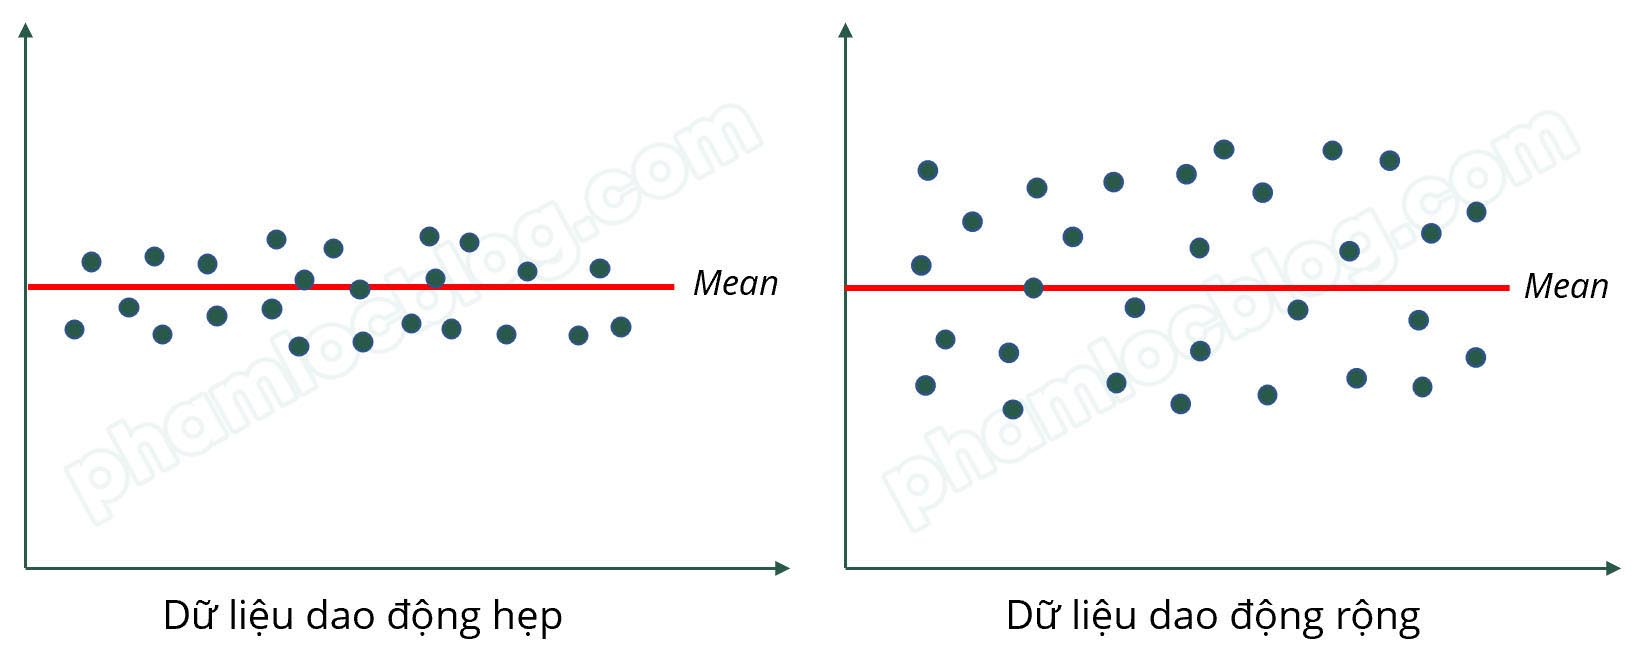

* Độ lệch tốt hay xấu phụ thuộc vào kỳ vọng của cta về dữ liệu 

Now we can choose to proceed with the set of features identified by RFE, but we can also take the route of directly going to ridge and lasso techniques. We can let the lasso model take care of feature selection as well. 

Bây giờ chúng tôi có thể chọn tiếp tục với tập hợp các tính năng được xác định bởi RFE, nhưng chúng tôi cũng có thể đi theo con đường trực tiếp đến các kỹ thuật ridge và lasso. Chúng ta cũng có thể để mô hình lasso đảm nhận việc lựa chọn tính năng.

<a id='9'></a>
## 7.2. Ridge Regression

In [73]:
#List of parameters (alpha values) to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


ridge = Ridge()
%time
# cross validation
folds = KFold(n_splits = 5, shuffle = True, random_state = 1)
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(x_train, y_train) 

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='r2', verbose=1)

In [74]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.011790,0.003865,0.005794,0.000747,0.0001,{'alpha': 0.0001},0.823831,0.879795,0.834613,0.845782,0.872595,0.851323,0.021582,24,0.922523,0.915727,0.924678,0.919550,0.916033,0.919702,0.003522
1,0.009991,0.001896,0.004395,0.000491,0.001,{'alpha': 0.001},0.823817,0.879748,0.834745,0.845917,0.872695,0.851384,0.021565,23,0.922522,0.915726,0.924677,0.919550,0.916031,0.919701,0.003521
2,0.008392,0.000489,0.004395,0.000490,0.01,{'alpha': 0.01},0.823855,0.879383,0.835664,0.847219,0.873241,0.851872,0.021367,22,0.922485,0.915704,0.924609,0.919542,0.915974,0.919663,0.003514
3,0.009592,0.001623,0.004795,0.001165,0.05,{'alpha': 0.05},0.825010,0.878445,0.837357,0.851620,0.874243,0.853335,0.020631,20,0.922306,0.915587,0.924319,0.919425,0.915776,0.919483,0.003472
4,0.009592,0.001623,0.004595,0.000490,0.1,{'alpha': 0.1},0.826595,0.877602,0.838472,0.855150,0.875156,0.854595,0.019982,19,0.922096,0.915432,0.924085,0.919193,0.915593,0.919280,0.003448


In [75]:
# this is the best value of alpha identified by grid search cv
# đây là giá trị alpha tốt nhất được xác định bởi cv tìm kiếm dạng lưới
model_cv.best_params_

{'alpha': 4.0}

In [76]:
# this is the best score obtained by grid search on the validation set
model_cv.best_score_

0.8663809457586471

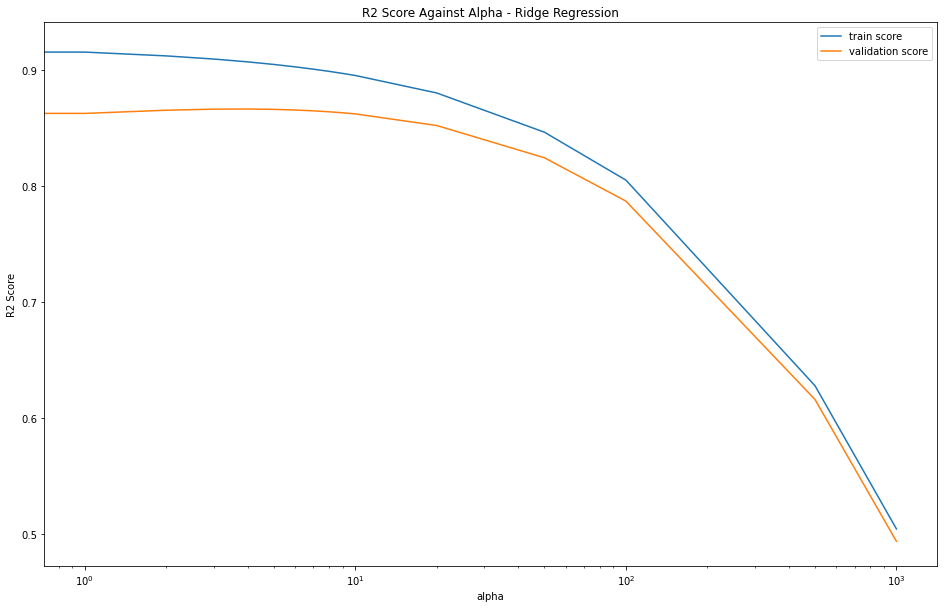

In [77]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')
plt.figure(figsize=(16,10))

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2 Score')
plt.title("R2 Score Against Alpha - Ridge Regression")
plt.legend(['train score', 'validation score'], loc='upper right')
plt.xscale('log')
plt.show()

In [78]:
# Selecting the optimum value of alpha as 4.0
ridge = Ridge(alpha = 4.0)
ridge.fit(x_train, y_train)

# predict
y_train_pred = ridge.predict(x_train)
y_test_pred = ridge.predict(x_test)

# Checking r2 score on train
print('r2 score for Train set')
print(metrics.r2_score(y_true = y_train, y_pred = y_train_pred))
print('r2 score for Test set')
print(metrics.r2_score(y_true = y_test, y_pred = y_test_pred))


r2 score for Train set
0.9045280752215418
r2 score for Test set
0.8932097820119711


In [79]:
# ridge model parameters
model_parameters = list(ridge.coef_)
model_parameters.insert(0, ridge.intercept_)
model_parameters = [round(x, 3) for x in model_parameters[1]]
cols = x_train.columns
cols = cols.insert(0, "constant")
ridge_f = list(zip(cols, model_parameters))
ridge_f

[('constant', -0.017),
 ('LotFrontage', 0.029),
 ('LotArea', -0.003),
 ('LotShape', 0.154),
 ('OverallQual', 0.108),
 ('OverallCond', 0.02),
 ('MasVnrArea', 0.016),
 ('ExterQual', 0.052),
 ('BsmtQual', 0.032),
 ('BsmtExposure', 0.023),
 ('BsmtFinType1', 0.005),
 ('BsmtFinSF1', 0.011),
 ('BsmtUnfSF', 0.023),
 ('TotalBsmtSF', 0.034),
 ('HeatingQC', 0.082),
 ('1stFlrSF', 0.073),
 ('2ndFlrSF', 0.1),
 ('GrLivArea', 0.036),
 ('BsmtFullBath', 0.063),
 ('FullBath', 0.042),
 ('HalfBath', 0.038),
 ('BedroomAbvGr', 0.044),
 ('KitchenQual', 0.067),
 ('TotRmsAbvGrd', 0.029),
 ('Fireplaces', 0.025),
 ('FireplaceQu', 0.007),
 ('GarageFinish', 0.073),
 ('GarageCars', 0.037),
 ('GarageArea', 0.023),
 ('WoodDeckSF', 0.002),
 ('OpenPorchSF', -0.04),
 ('Age', -0.008),
 ('RoofStyle_Gable', -0.026),
 ('RoofStyle_Gambrel', 0.0),
 ('RoofStyle_Hip', 0.016),
 ('RoofStyle_Mansard', 0.002),
 ('RoofStyle_Shed', 0.011),
 ('SaleCondition_AdjLand', 0.02),
 ('SaleCondition_Alloca', -0.006),
 ('SaleCondition_Family', 0

In [80]:
d = {'Feature':list(list(zip(*ridge_f))[0]),'Coeff':list(list(zip(*ridge_f))[1])}
ridge_params = pd.DataFrame(data = d)

In [81]:
# Let's see what is the importance given to each feature by our model
# Hãy xem tầm quan trọng của từng tính năng theo mô hình của chúng ta là gì

ridge_params.reindex(ridge_params.Coeff.abs().sort_values(ascending = False).index)

,Feature,Coeff
3,LotShape,0.154
4,OverallQual,0.108
16,2ndFlrSF,0.100
14,HeatingQC,0.082
26,GarageFinish,0.073
15,1stFlrSF,0.073
22,KitchenQual,0.067
18,BsmtFullBath,0.063
60,MSZoning_RH,0.054
7,ExterQual,0.052


#### Ridge Model Explained
* Using ridge regression to regularize our parameters, we were able to determine the value of alpha (hyperparameter) to be optimal at 4.0
* Upon choosing this value, our model performs at a train set best r-squared of 0.87 during 5-fold cross validation. 
* We obtained a test data r2 value of 0.89 on fitting the model on training data (which gave train data r-squared of 0.90, indicating a good stable model)
* The important features can be observed in the sorted dataframe in the above cell.
    * OverallQual - High rating for the overall quality tends to bump the price up
    * LotShape - Regularly shaped lots would fetch a higher price for the house
    * 2nd/1st Floor Area - The area of both floors contribute to the price of the house.
    * HeatingQC - Houses equipped with better heating fetch better prices
    * GarageFinish - Better finish in the garage causes bump in price. 
    * KitchenQual - A hgher quality kitchen adds to the price
    * Basements that contain a full bath add value a lot.
    * High density residental zones are a major selling point
    * The quality of material used on the exterior is also being observed to impact the cost considerably.
    * There are certain neighborhood which are more preferred as well: 
        * Somerset
        * College Creek
        * North Ridge

* Sử dụng hồi quy sườn để chuẩn hóa các tham số của chúng tôi, chúng tôi có thể xác định giá trị của alpha (siêu tham số) là tối ưu ở 4.0
* Khi chọn giá trị này, mô hình của chúng tôi hoạt động ở mức r bình phương tốt nhất được đặt là 0,87 trong quá trình xác thực chéo 5 lần.
* Chúng tôi đã thu được giá trị r2 của dữ liệu thử nghiệm là 0,89 khi điều chỉnh mô hình trên dữ liệu huấn luyện (giá trị này cho dữ liệu huấn luyện r bình phương là 0,90, cho thấy một mô hình ổn định tốt)
* Các tính năng quan trọng có thể được quan sát trong khung dữ liệu được sắp xếp trong ô trên.
    * OverallQual - Đánh giá cao về chất lượng tổng thể có xu hướng tăng giá
    * LotShape - Các lô có hình dạng thông thường sẽ bán được giá cao hơn cho ngôi nhà
    * Diện tích tầng 2/tầng 1 - Diện tích của cả 2 tầng đóng góp vào giá nhà.
    * HeatingQC - Những ngôi nhà được trang bị hệ thống sưởi tốt hơn sẽ có giá tốt hơn
    * GarageFinish - Hoàn thiện tốt hơn trong nhà để xe gây tăng giá.
    * KitchenQual - Bếp chất lượng cao hơn làm tăng giá
    * Tầng hầm có đầy đủ phòng tắm sẽ tăng giá trị rất nhiều.
    * Khu dân cư mật độ cao là một điểm bán hàng lớn
    * Chất lượng của vật liệu được sử dụng ở bên ngoài cũng được quan sát là có tác động đáng kể đến chi phí.
    * Có một số vùng lân cận cũng được ưu tiên hơn:
        * Somerset
        * College Creek
        * North Ridge

<a id='10'></a>
## 7.3. Lasso Regression

In [82]:
#List of parameters (alpha values) to tune
params = {'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


lasso = Lasso()
%time
# cross validation
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(x_train, y_train) 

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                   0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.01,
                                   0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                   0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,
                                   9.0, ...]},
             return_train_score=True, scoring='r2', verbose=1)

In [83]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head(50)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.043159,0.014317,0.004995,0.001094,0.0001,{'alpha': 0.0001},0.807489,0.864939,0.889758,0.866915,0.912611,0.868342,0.035029,4,0.922052,0.914238,0.911052,0.910247,0.905111,0.912540,0.005586
1,0.019981,0.003519,0.004196,0.000399,0.0002,{'alpha': 0.0002},0.819721,0.863377,0.893023,0.867304,0.910935,0.870872,0.030923,2,0.913853,0.908075,0.902254,0.905903,0.895537,0.905124,0.006094
2,0.014786,0.002711,0.005196,0.000979,0.0003,{'alpha': 0.0003},0.824899,0.863269,0.893327,0.866665,0.909120,0.871456,0.028825,1,0.908728,0.903616,0.896098,0.901883,0.891469,0.900359,0.006003
3,0.016183,0.001720,0.004797,0.000978,0.0004,{'alpha': 0.0004},0.825076,0.861365,0.891167,0.864297,0.906455,0.869672,0.027935,3,0.905987,0.899512,0.892562,0.897953,0.887692,0.896741,0.006229
4,0.014384,0.002725,0.005596,0.000799,0.0005,{'alpha': 0.0005},0.825246,0.859241,0.888849,0.861236,0.903205,0.867555,0.026920,5,0.902877,0.895904,0.889299,0.894254,0.884035,0.893274,0.006345
5,0.013985,0.003030,0.004997,0.000633,0.0006,{'alpha': 0.0006},0.825750,0.856451,0.885636,0.858621,0.899295,0.865151,0.025519,6,0.899692,0.892037,0.885510,0.891071,0.879868,0.889636,0.006654
6,0.015185,0.001938,0.004796,0.000749,0.0007,{'alpha': 0.0007},0.825608,0.853579,0.882206,0.856298,0.894738,0.862486,0.024111,7,0.896162,0.888282,0.881578,0.888088,0.875553,0.885933,0.006950
7,0.013786,0.001937,0.005395,0.001019,0.0008,{'alpha': 0.0008},0.825795,0.849998,0.878839,0.853703,0.889648,0.859596,0.022551,8,0.892585,0.884518,0.877691,0.884849,0.871536,0.882236,0.007131
8,0.014186,0.002224,0.005795,0.000748,0.0009,{'alpha': 0.0009},0.826009,0.845752,0.874812,0.851416,0.884832,0.856564,0.021020,9,0.888915,0.880608,0.873745,0.881568,0.867609,0.878489,0.007260
9,0.012988,0.001263,0.004596,0.000489,0.001,{'alpha': 0.001},0.825938,0.841544,0.871010,0.848856,0.880764,0.853622,0.019870,10,0.885288,0.876664,0.869344,0.878043,0.863783,0.874624,0.007416


In [84]:
model_cv.best_params_

{'alpha': 0.0003}

In [85]:
model_cv.best_score_

0.8714563058320539

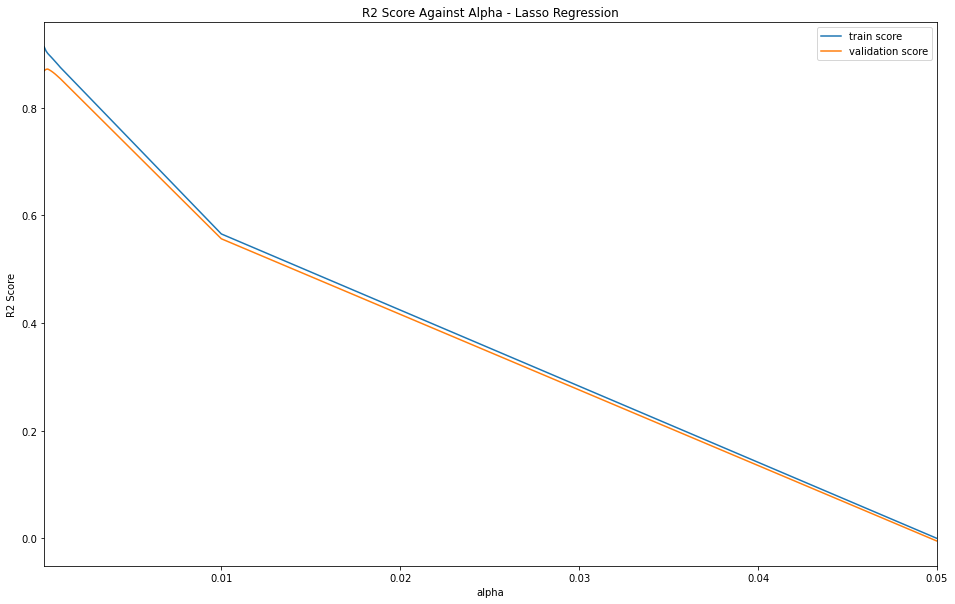

In [86]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float64')
plt.figure(figsize=(16,10))

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2 Score')
plt.title("R2 Score Against Alpha - Lasso Regression")
plt.legend(['train score', 'validation score'], loc='upper right')
# plt.xscale('log')
plt.xlim(0.0001,0.05)
plt.show()


In [87]:
# Selecting the optimum value of alpha as 0.0003
lasso = Lasso(alpha = 0.0003)
lasso.fit(x_train, y_train)

# predict
y_train_pred = lasso.predict(x_train)
y_test_pred = lasso.predict(x_test)

# Checking r2 score on train
print('r2 score for Train set')
print(metrics.r2_score(y_true = y_train, y_pred = y_train_pred))
print('r2 score for Test set')
print(metrics.r2_score(y_true = y_test, y_pred = y_test_pred))


r2 score for Train set
0.8972833464509106
r2 score for Test set
0.8900248639583314


In [88]:
# lasso model parameters
model_parameters = list(lasso.coef_)
model_parameters.insert(0, lasso.intercept_)
model_parameters = [round(x, 3) for x in model_parameters[1:]]
cols = x_train.columns
cols = cols.insert(0, "constant")
lasso_f = list(zip(cols, model_parameters))
lasso_f

[('constant', -0.0),
 ('LotFrontage', 0.0),
 ('LotArea', -0.0),
 ('LotShape', 0.233),
 ('OverallQual', 0.126),
 ('OverallCond', 0.0),
 ('MasVnrArea', 0.0),
 ('ExterQual', 0.06),
 ('BsmtQual', 0.028),
 ('BsmtExposure', 0.019),
 ('BsmtFinType1', 0.0),
 ('BsmtFinSF1', 0.0),
 ('BsmtUnfSF', 0.0),
 ('TotalBsmtSF', 0.031),
 ('HeatingQC', 0.0),
 ('1stFlrSF', 0.0),
 ('2ndFlrSF', 0.344),
 ('GrLivArea', 0.034),
 ('BsmtFullBath', 0.044),
 ('FullBath', 0.027),
 ('HalfBath', 0.0),
 ('BedroomAbvGr', 0.035),
 ('KitchenQual', 0.051),
 ('TotRmsAbvGrd', 0.017),
 ('Fireplaces', 0.025),
 ('FireplaceQu', 0.004),
 ('GarageFinish', 0.106),
 ('GarageCars', 0.0),
 ('GarageArea', 0.016),
 ('WoodDeckSF', 0.0),
 ('OpenPorchSF', -0.032),
 ('Age', -0.003),
 ('RoofStyle_Gable', -0.0),
 ('RoofStyle_Gambrel', 0.0),
 ('RoofStyle_Hip', 0.0),
 ('RoofStyle_Mansard', 0.0),
 ('RoofStyle_Shed', 0.0),
 ('SaleCondition_AdjLand', 0.0),
 ('SaleCondition_Alloca', -0.0),
 ('SaleCondition_Family', 0.015),
 ('SaleCondition_Normal', 0

In [89]:
d = {'Feature':list(list(zip(*lasso_f))[0]),'Coeff':list(list(zip(*lasso_f))[1])}
lasso_params = pd.DataFrame(data = d)

In [90]:
# Hãy xem tầm quan trọng của từng tính năng theo mô hình của chúng tôi là gì
lasso_params.reindex(lasso_params.Coeff.abs().sort_values(ascending = False).index)

,Feature,Coeff
16,2ndFlrSF,0.344
3,LotShape,0.233
4,OverallQual,0.126
26,GarageFinish,0.106
7,ExterQual,0.060
22,KitchenQual,0.051
90,Neighborhood_CollgCr,0.046
18,BsmtFullBath,0.044
105,Neighborhood_SawyerW,0.040
100,Neighborhood_NoRidge,0.040


#### Lasso model explained
* Using Lasso regression to regularize our parameters, we were able to determine the value of alpha (hyperparameter) to be optimal at 0.0003
* Lasso has an added benefit of performing feature selection. 
* Upon choosing this value, our model performs at a validation set r-squared of 0.87 during 5-fold cross validation. 
* We obtained a test data r2 value of 0.89 on fitting the model on training data (which gave train data r-squared of 0.90, indicating a good stable model)
* The most important features can be observed in the sorted dataframe in the above cell.
    * 2ndFloorSF - The are of the second floor
    * Lot Shape - The shape of the lot regular/irregular etc. The more it is towards regular, higher is the price
    * OverallQual - High rating (9/10) for the overall quality tends to bump the price up. 
    * ExterQual - The quality of material with which the exterior of house is buuilt
    * GarageFinish - Interiror finish of the garage
    * Some neighborhoods fetch better prices for the house
        * North Ridge
        * College Creek
        * Wayer West
    * Sales which are made as 'partial' will bring the price down considerably. 
    

These models can be further tuned using feature selection techniques like Forward, Backward and Stepwise. 

Các mô hình này có thể được điều chỉnh thêm bằng cách sử dụng các kỹ thuật lựa chọn tính năng như Forward, Backward and Stepwise.

<a id='11'></a>
# 8. Understanding Alpha

### Doubling the values of Alpha

In [91]:
# Doubling the alpha for ridge to 8.0
ridge = Ridge(alpha = 8.0)
ridge.fit(x_train, y_train)

# predict
y_train_pred = ridge.predict(x_train)
y_test_pred = ridge.predict(x_test)

# Checking r2 score on train
print('r2 score for Train set')
print(metrics.r2_score(y_true = y_train, y_pred = y_train_pred))
print('r2 score for Test set')
print(metrics.r2_score(y_true = y_test, y_pred = y_test_pred))

r2 score for Train set
0.8979450717033688
r2 score for Test set
0.8887830506571055


In [92]:
# Ridge Model Parameters
model_parameters = list(ridge.coef_)
model_parameters.insert(0, ridge.intercept_)
model_parameters = [round(x, 3) for x in model_parameters[1]]
cols = x_train.columns
cols = cols.insert(0, "constant")
ridge_f = list(zip(cols, model_parameters))

#Hãy xem tầm quan trọng của từng tính năng theo mô hình của chúng ta là gì
pd.DataFrame(data = {'Feature':list(list(zip(*ridge_f))[0]),'Coeff':list(list(zip(*ridge_f))[1])}).reindex(ridge_params.Coeff.abs().sort_values(ascending = False).index)

,Feature,Coeff
3,LotShape,0.127
4,OverallQual,0.092
16,2ndFlrSF,0.080
14,HeatingQC,0.065
26,GarageFinish,0.066
15,1stFlrSF,0.062
22,KitchenQual,0.065
18,BsmtFullBath,0.062
60,MSZoning_RH,0.037
7,ExterQual,0.049


In [93]:
# Doubling the alpha for lasso to 0.0006
lasso = Lasso(alpha = 0.0006)
lasso.fit(x_train, y_train)

# predict
y_train_pred = lasso.predict(x_train)
y_test_pred = lasso.predict(x_test)

# Checking r2 score on train
print('r2 score for Train set')
print(metrics.r2_score(y_true = y_train, y_pred = y_train_pred))
print('r2 score for Test set')
print(metrics.r2_score(y_true = y_test, y_pred = y_test_pred))


r2 score for Train set
0.8872690186670561
r2 score for Test set
0.8783311570389485


In [94]:
# Lasso Model Parameters
model_parameters = list(lasso.coef_)
model_parameters.insert(0, lasso.intercept_)
model_parameters = [round(x, 3) for x in model_parameters[1:]]
cols = x_train.columns
cols = cols.insert(0, "constant")
lasso_f = list(zip(cols, model_parameters))

# Let's see what is the importance given to each feature by our model
d = {'Feature':list(list(zip(*lasso_f))[0]),'Coeff':list(list(zip(*lasso_f))[1])}
lasso_params = pd.DataFrame(data = d)
lasso_params.reindex(lasso_params.Coeff.abs().sort_values(ascending = False).index)

,Feature,Coeff
16,2ndFlrSF,0.300
3,LotShape,0.243
26,GarageFinish,0.113
4,OverallQual,0.103
7,ExterQual,0.059
22,KitchenQual,0.046
21,BedroomAbvGr,0.041
18,BsmtFullBath,0.039
90,Neighborhood_CollgCr,0.037
105,Neighborhood_SawyerW,0.036


We see a dip in the train r-squared for both the models, for both train set and test set. This is to be expected since the model is now more regularized and the fit is less tighter than it was before.

Chúng tôi thấy sự giảm nhẹ trong bình phương r ( r-squared) của đoàn tàu cho cả hai mô hình, cho cả tập luyện và kiểm tra. Điều này được mong đợi vì mô hình hiện đã được điều chỉnh hợp lý hơn và độ vừa phải ít chặt chẽ hơn so với trước đây.

<a id='12'></a>
# 9. Re-Run Lasso with Reduced set of input variables

* The top 5 features from the orignal Lasso model were ['2ndFlrSF','LotShape','OverallQual','ExterQual','GarageFinish'].
* These will be removed from the training (and test) set, and the model will be re-tuned and re-evaluated.

* 5 tính năng hàng đầu từ mô hình Lasso gốc là ['2ndFlrSF','LotShape','OverallQual','ExterQual','GarageFinish'].
* Chúng sẽ bị xóa khỏi tập huấn luyện (và kiểm tra) và mô hình sẽ được điều chỉnh lại và đánh giá lại.

In [95]:
#List of parameters (alpha values) to tune
params = {'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


lasso = Lasso()
%time
# cross validation
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(x_train.drop(['2ndFlrSF','LotShape','OverallQual','ExterQual','GarageFinish'],axis=1), y_train) #top features removed

CPU times: total: 0 ns
Wall time: 1 ms
Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                   0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.01,
                                   0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                   0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,
                                   9.0, ...]},
             return_train_score=True, scoring='r2', verbose=1)

In [96]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.068138,0.005806,0.007393,0.001355,0.0001,{'alpha': 0.0001},0.784199,0.860426,0.884815,0.856709,0.897529,0.856736,0.039313,4,0.916526,0.905890,0.902618,0.902911,0.898281,0.905245,0.006140
1,0.040363,0.016797,0.008391,0.001623,0.0002,{'alpha': 0.0002},0.797065,0.858851,0.890492,0.855112,0.893310,0.858966,0.034699,2,0.908095,0.899105,0.894183,0.897058,0.887949,0.897278,0.006588
2,0.020979,0.002096,0.007993,0.002096,0.0003,{'alpha': 0.0003},0.802056,0.859992,0.891394,0.856090,0.890405,0.859987,0.032505,1,0.901788,0.894248,0.886041,0.892378,0.883474,0.891586,0.006455
3,0.020382,0.002152,0.010190,0.003308,0.0004,{'alpha': 0.0004},0.803382,0.858308,0.889873,0.853085,0.886206,0.858171,0.031044,3,0.898015,0.888846,0.881248,0.888480,0.879354,0.887188,0.006608
4,0.049753,0.039381,0.009591,0.001623,0.0005,{'alpha': 0.0005},0.803453,0.854896,0.887056,0.848946,0.882431,0.855357,0.029911,5,0.894194,0.884788,0.876965,0.884495,0.875329,0.883154,0.006721


In [97]:
model_cv.best_params_

{'alpha': 0.0003}

In [98]:
model_cv.best_score_

0.8599872893856955

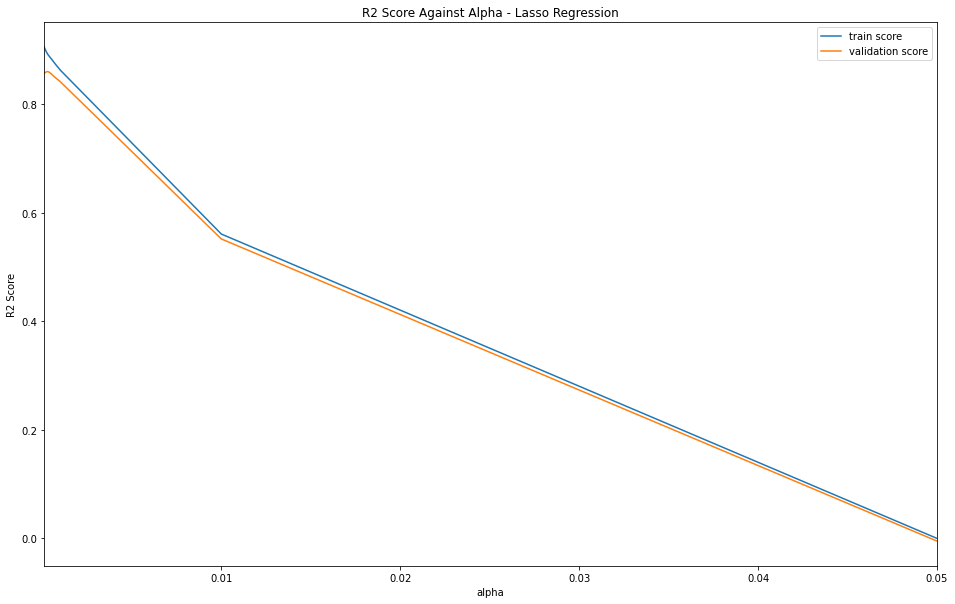

In [99]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float64')
plt.figure(figsize=(16,10))

# plotting
plt.plot(cv_results.loc[cv_results['param_alpha']<=1.0]['param_alpha'], cv_results.loc[cv_results['param_alpha']<=1.0]['mean_train_score'])
plt.plot(cv_results.loc[cv_results['param_alpha']<=1.0]['param_alpha'], cv_results.loc[cv_results['param_alpha']<=1.0]['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2 Score')
plt.title("R2 Score Against Alpha - Lasso Regression")
plt.legend(['train score', 'validation score'], loc='upper right')
plt.xlim(0.0001,0.05)
# plt.xscale('log')
plt.show()

In [100]:
# Selecting the optimum value of alpha as 0.0003
lasso = Lasso(alpha = 0.0003)
lasso.fit(x_train.drop(['2ndFlrSF','LotShape','OverallQual','ExterQual','GarageFinish'],axis=1), y_train)
#predict
y_train_pred = lasso.predict(x_train.drop(['2ndFlrSF','LotShape','OverallQual','ExterQual','GarageFinish'],axis=1))
y_test_pred = lasso.predict(x_test.drop(['2ndFlrSF','LotShape','OverallQual','ExterQual','GarageFinish'],axis=1))
#Checking r2 score on train
print('r2 score for Train set')
print(metrics.r2_score(y_true = y_train, y_pred = y_train_pred))
print('r2 score for Test set')
print(metrics.r2_score(y_true = y_test, y_pred = y_test_pred))


r2 score for Train set
0.888291425255553
r2 score for Test set
0.8806637429900877


In [101]:
# lasso model parameters
model_parameters = list(lasso.coef_)
model_parameters.insert(0, lasso.intercept_)
model_parameters = [round(x, 3) for x in model_parameters[1:]]
cols = x_train.drop(['2ndFlrSF','LotShape','OverallQual','ExterQual','GarageFinish'],axis=1).columns
cols = cols.insert(0, "constant")
lasso_f = list(zip(cols, model_parameters))
lasso_f

[('constant', -0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.148),
 ('OverallCond', 0.0),
 ('MasVnrArea', 0.087),
 ('BsmtQual', 0.035),
 ('BsmtExposure', 0.021),
 ('BsmtFinType1', 0.0),
 ('BsmtFinSF1', 0.006),
 ('BsmtUnfSF', 0.0),
 ('TotalBsmtSF', 0.034),
 ('HeatingQC', 0.0),
 ('1stFlrSF', 0.448),
 ('GrLivArea', 0.029),
 ('BsmtFullBath', 0.042),
 ('FullBath', 0.026),
 ('HalfBath', 0.0),
 ('BedroomAbvGr', 0.058),
 ('KitchenQual', 0.051),
 ('TotRmsAbvGrd', 0.018),
 ('Fireplaces', 0.036),
 ('FireplaceQu', 0.113),
 ('GarageCars', 0.0),
 ('GarageArea', 0.01),
 ('WoodDeckSF', 0.0),
 ('OpenPorchSF', -0.075),
 ('Age', -0.001),
 ('RoofStyle_Gable', -0.0),
 ('RoofStyle_Gambrel', 0.008),
 ('RoofStyle_Hip', 0.0),
 ('RoofStyle_Mansard', 0.0),
 ('RoofStyle_Shed', 0.0),
 ('SaleCondition_AdjLand', 0.0),
 ('SaleCondition_Alloca', -0.0),
 ('SaleCondition_Family', 0.015),
 ('SaleCondition_Normal', 0.019),
 ('SaleCondition_Partial', 0.0),
 ('LandContour_HLS', 0.0),
 ('LandContour_Low', 0.002),
 ('LandContou

In [102]:
d = {'Feature':list(list(zip(*lasso_f))[0]),'Coeff':list(list(zip(*lasso_f))[1])}
lasso_params = pd.DataFrame(data = d)

In [103]:
# Let's see what is the importance given to each feature by our model
lasso_params.reindex(lasso_params.Coeff.abs().sort_values(ascending = False).index)

,Feature,Coeff
12,1stFlrSF,0.448
2,LotArea,0.148
21,FireplaceQu,0.113
4,MasVnrArea,0.087
25,OpenPorchSF,-0.075
17,BedroomAbvGr,0.058
95,Neighborhood_NoRidge,0.054
18,KitchenQual,0.051
101,Neighborhood_Somerst,0.050
100,Neighborhood_SawyerW,0.046


* Tham khảo thêm 

https://towardsdatascience.com/powerful-feature-selection-with-recursive-feature-elimination-rfe-of-sklearn-23efb2cdb54e

https://github.com/namanarora42/Data-Science-Notebooks/blob/main/HousePricePrediction-Ridge-Lasso/house-price-prediction-ridge-and-lasso-regression.ipynb

# End of Notebook